In [30]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# We will be relying on a pre-defined set of functions from util.py
from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor),1) # Combining input and hidden layers
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
     
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    


In [32]:
import io
import os
import unicodedata
import string
import glob

import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



In [73]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

In [45]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# One Step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn.forward(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [57]:
# Whole sequence/name
input_tensor = letter_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [67]:
# Gets the output
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Polish


In [83]:
lossfx = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr = 0.001)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn.forward(line_tensor[i], hidden)
    optimizer.zero_grad()
    loss = lossfx(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

4999 4.999 2.4460 Faolan / Irish CORRECT
9999 9.998999999999999 2.5525 Vazyulin / Scottish WRONG Russian
14999 14.999 2.8300 Edmunds / Greek WRONG English
19999 19.999 1.3897 Ruan / Chinese CORRECT
24999 24.999 2.2976 Trnkova / Japanese WRONG Czech
29999 29.999 2.0205 Dvorak / Czech CORRECT
34999 34.999 2.3072 Izumi / Arabic WRONG Japanese
39999 39.999 1.3319 Mancini / Italian CORRECT
44999 44.999 2.0629 Mayer / Arabic WRONG German
49999 49.999 0.3773 Tsukehara / Japanese CORRECT
54999 54.998999999999995 3.5915 Gaspar / Arabic WRONG Spanish
59999 59.999 2.0210 Mansour / French WRONG Arabic
64999 64.999 1.0315 Nelli / Italian CORRECT
69999 69.999 1.6850 Lavigne / French CORRECT
74999 74.99900000000001 1.3817 Perez / Spanish CORRECT
79999 79.999 1.0061 Sneijders / Dutch CORRECT
84999 84.999 1.2598 Amello / Italian CORRECT
89999 89.999 3.1317 Furlan / Irish WRONG Italian
94999 94.999 4.1800 Baarle / French WRONG Dutch
99999 99.99900000000001 0.8480 Gomulka / Polish CORRECT


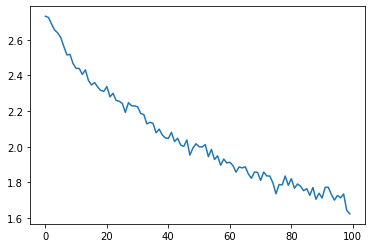

In [86]:
current_loss = 0
all_losses = [] # To plot later
plot_steps, print_steps = 1000, 5000
EPOCHS = 100000

for epoch in range(EPOCHS):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    if (epoch+1)% plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    if (epoch+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG {category}"
        print(f"{epoch} {epoch/EPOCHS*100} {loss:.4f} {line} / {guess} {correct}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

<b>Making predictions with our trained model</b>

In [95]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)
        
while True:
    sentence = input("Input: ")
    if sentence == "quit":
        break
    predict(sentence)

Input: bao

> bao
Chinese
Input: nao

> nao
Chinese
Input: mao

> mao
Chinese
Input: hao

> hao
Chinese
Input: Yi Hao

> Yi Hao
Arabic
Input:  quit

>  quit
Arabic
Input: quit
